## computing gene/peak correlations from single-cell multiome datasets

- Last updated: 2/1/2024
- Author: Yang-Joon Kim
- Description: 
The goal is to compute the correlation between genes and peaks at Metacell (SEACells) level. We used "SEACells" to compute the metacells, resulting in two adata objects (adata_rna, and adata_atac), whose rows represent meta cells, and columns represent features (genes for RNA and peaks for ATAC). 

1) We subset the data per chromosome (metacells-by-genes (chr1), and metacells-by-peaks(chr1))
2) computing the correlation coefficients for all paris of genes/peaks within the same chromosome. Save the result as a dataframe (genes-by-peaks, chr1)
3) Repeat the process for all chromosomes (loop), then merge the output dataframes, note that the final output will be a sparse matrix.
4) visualize the result (distribution of correlation coefficients).
5) [maybe another notebook] repeat the correlation computation for the pairs of genes/TSS (imported from Ensemble?)

In [16]:
## We will use pyensembl library to map the gene names to which chromosome they belong to.


In [2]:
from pyensembl import EnsemblRelease

# Use the appropriate Ensembl release
data = EnsemblRelease(111, species="danio_rerio")
data.download()
data.index()

INFO:pyensembl.sequence_data:Loaded sequence dictionary from /hpc/mydata/yang-joon.kim/.cache/pip:/pyensembl/GRCz11/ensembl111/Danio_rerio.GRCz11.cdna.all.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /hpc/mydata/yang-joon.kim/.cache/pip:/pyensembl/GRCz11/ensembl111/Danio_rerio.GRCz11.ncrna.fa.gz.pickle
INFO:pyensembl.sequence_data:Loaded sequence dictionary from /hpc/mydata/yang-joon.kim/.cache/pip:/pyensembl/GRCz11/ensembl111/Danio_rerio.GRCz11.pep.all.fa.gz.pickle


In [3]:
# Example gene list
gene_list = ['ptpn12', 'phtf2', 'phtf2.1', 'CU856344.1', 'si:zfos-932h1.3']

def get_chromosome(gene_name):
    try:
        gene = data.genes_by_name(gene_name)
        return gene[0].contig
    except ValueError:
        return "None"  # or "unknown" if gene name not found


# Get chromosomes for each gene in the list
chromosome_list = [get_chromosome(gene) for gene in gene_list]
chromosome_list

['4', '4', 'None', '4', '4']

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
rna_meta_ad = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/05_SEACells_processed/TDR118reseq/TDR118_RNA_seacells_aggre.h5ad")
rna_meta_ad

AnnData object with n_obs × n_vars = 180 × 32057
    obs: 'n_counts'
    uns: 'log1p'
    layers: 'raw'

In [43]:
# Get chromosomes for each gene in the list
chromosome_list = [get_chromosome(gene) for gene in rna_meta_ad.var_names]
chromosome_list

rna_meta_ad.var["chromosome"] = chromosome_list

In [44]:
rna_meta_ad.var

,chromosome
ptpn12,4
phtf2,4
phtf2.1,None
CU856344.1,4
si:zfos-932h1.3,4
...,...
mt-nd6,MT
NC-002333.21,None
mt-cyb,MT
NC-002333.22,None


In [45]:
rna_meta_ad.var["chromosome"].iloc[2]

'None'

In [47]:
rna_meta_ad[:,rna_meta_ad.var["chromosome"]=="None"].var_names

Index(['phtf2.1', 'ptpro.1', 'si:dkey-61f9.1.1', 'C4H12orf66',
       'si:dkey-21h14.12.1', 'si:dkey-21h14.12.2', 'ENSDARG00000081841',
       'plxnb2a.1', 'ENSDARG00000083126', 'mcat.1',
       ...
       'NC-002333.24', 'NC-002333.2', 'NC-002333.12', 'NC-002333.3',
       'NC-002333.16', 'NC-002333.15', 'NC-002333.8', 'NC-002333.21',
       'NC-002333.22', 'NC-002333.11'],
      dtype='object', length=982)

### NOTE.
We will ignore the genes which were not mapped to chromosomes easily as they are likely some weird names in the reference genome, mitochondrial, microRNAs, etc.

In [49]:
atac_meta_ad = sc.read_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/05_SEACells_processed/TDR118reseq/TDR118_ATAC_seacells_aggre.h5ad")
atac_meta_ad

AnnData object with n_obs × n_vars = 180 × 485357
    obs: 'n_counts'
    var: 'GC_bin', 'counts_bin', 'n_cells'
    uns: 'log1p'
    obsm: 'X_svd'
    layers: 'raw'

In [50]:
atac_meta_ad.var

,GC_bin,counts_bin,n_cells
1-3427-4032,25,20,129
1-4473-6136,25,26,172
1-11020-12944,25,31,177
1-13368-13575,25,19,124
1-14640-15050,25,25,166
...,...,...,...
9-56298513-56299501,25,14,77
9-56396807-56397687,25,14,79
9-56400365-56401096,25,19,139
9-56411957-56412701,25,18,124


In [51]:
# Extract chromosome number
def extract_chromosome(peak_str):
    # Split the string by '-' and return the first element (chromosome number)
    return peak_str.split('-')[0]

In [52]:
atac_meta_ad.var['chromosome'] = atac_meta_ad.var_names.map(extract_chromosome)
atac_meta_ad.var

,GC_bin,counts_bin,n_cells,chromosome
1-3427-4032,25,20,129,1
1-4473-6136,25,26,172,1
1-11020-12944,25,31,177,1
1-13368-13575,25,19,124,1
1-14640-15050,25,25,166,1
...,...,...,...,...
9-56298513-56299501,25,14,77,9
9-56396807-56397687,25,14,79,9
9-56400365-56401096,25,19,139,9
9-56411957-56412701,25,18,124,9


In [ ]:
# Initialize an empty DataFrame to store gene-peak correlations
gene_peak_correlations = pd.DataFrame()

In [60]:
# recover the raw counts
rna_meta_ad.X = rna_meta_ad.raw.X.copy()
atac_meta_ad.X = atac_meta_ad.raw.X.copy()

# log-normalize the counts
sc.pp.normalize_total(rna_meta_ad, target_sum=1e4)
sc.pp.log1p(rna_meta_ad)

sc.pp.normalize_total(atac_meta_ad, target_sum=1e4)
sc.pp.log1p(atac_meta_ad)

In [56]:
chrom = "1"

# subset the adata_rna for one chromosome
rna_subset = rna_meta_ad[:,rna_meta_ad.var["chromosome"]==chrom]

# subset the adata_atac for one chromosome
atac_subset = atac_meta_ad[:,atac_meta_ad.var["chromosome"]==chrom]

In [91]:
# rna_subset.X[:,1].toarray()

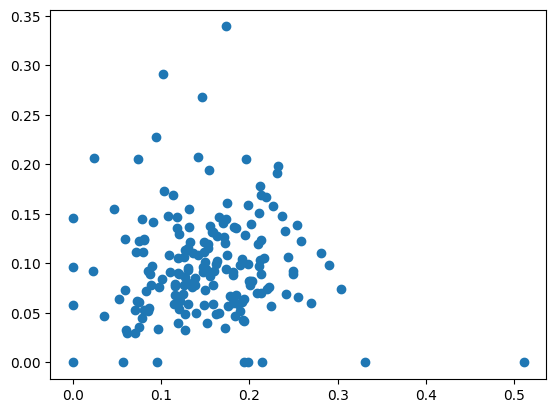

In [90]:
plt.scatter(rna_subset.X[:,1].toarray(), atac_subset.X[:,1].toarray())

In [97]:
rna_subset.var_names

Index(['rpl24', 'cep97', 'nfkbiz', 'CU651657.1', 'eed', 'hikeshi', 'tmem39a',
       'ildr1a', 'si:zfos-1011f11.2', 'gpa33a',
       ...
       'FP236157.6', 'FP236157.5', 'FP236157.8', 'FP236157.7', 'FP236157.1',
       'FP236157.3', 'sp6', 'FP236157.2', 'zmp:0000001082', 'wfikkn1'],
      dtype='object', length=1415)

In [101]:
rna_matrix.shape[1]

1415

In [102]:
rna_subset.X.A

array([[3.07816134, 0.07017534, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.27255983, 0.11946508, 0.03561364, ..., 0.        , 0.        ,
        0.05295585],
       [3.12457256, 0.11894467, 0.        , ..., 0.        , 0.02494772,
        0.04928817],
       ...,
       [3.29866607, 0.15549446, 0.08076651, ..., 0.        , 0.        ,
        0.        ],
       [3.05755851, 0.13833282, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [3.09183825, 0.51115918, 0.        , ..., 0.        , 0.        ,
        0.10544392]])

In [112]:
pearsonr(rna_matrix[:, 0].A.flatten(), atac_matrix[:, 0].A.flatten())

PearsonRResult(statistic=0.036534693387979024, pvalue=0.6263206148971928)

In [113]:
from scipy.stats import pearsonr

# Function to compute correlation coefficient
def compute_correlation(x, y):
    x_dense = x.A.flatten()  # Convert to dense format and flatten
    y_dense = y.A.flatten()
    corr, _ = pearsonr(x_dense, y_dense)
    return corr


compute_correlation(rna_matrix[:, 0], atac_matrix[:, 0])

0.036534693387979024

In [121]:
rna_matrix

<180x1415 sparse matrix of type '<class 'numpy.float64'>'
	with 114259 stored elements in Compressed Sparse Row format>

In [114]:
from scipy.stats import pearsonr

# extract the count matrices (log-norm)
rna_matrix = rna_subset.X
atac_matrix = atac_subset.X

# Number of genes and peaks
num_genes = rna_matrix.shape[1]
num_peaks = atac_matrix.shape[1]

# Initialize an empty DataFrame to store gene-peak correlations
gene_peak_correlations = pd.DataFrame(index=rna_subset.var_names, columns=atac_subset.var_names)

# Function to compute correlation coefficient
def compute_correlation(x, y):
    x_dense = x.A.flatten()  # Convert to dense format and flatten
    y_dense = y.A.flatten()
    corr, _ = pearsonr(x_dense, y_dense)
    return corr

# Compute correlations
for i in range(num_genes):
    for j in range(num_peaks):
        gene_vector = rna_matrix[:, i]
        peak_vector = atac_matrix[:, j]
        correlation = compute_correlation(gene_vector, peak_vector)
        gene_peak_correlations.iloc[i, j] = correlation


KeyboardInterrupt: 

In [115]:
gene_peak_correlations

,1-3427-4032,1-4473-6136,1-11020-12944,1-13368-13575,1-14640-15050,1-16769-17193,1-17780-17992,1-18477-20032,1-21216-21436,1-23357-23611,1-27143-28515,1-29541-29912,1-35279-35560,1-36500-38297,1-42432-42671,1-43648-44789,1-47922-48323,1-48901-50727,1-55696-55927,1-58482-58798,1-59014-59231,1-59476-61085,1-62803-63364,1-63880-64103,1-64580-65338,1-70906-72712,1-73471-74755,1-78056-78702,1-79154-79353,1-83700-84197,1-84297-84654,1-85791-86597,1-90307-90851,1-92146-92785,1-93230-93877,1-95999-96339,1-97532-98113,1-99584-99971,1-102124-102904,1-104085-104379,...,1-55040888-55041689,1-55103911-55104729,1-55122667-55123684,1-55174352-55175143,1-55186423-55187206,1-55195053-55195614,1-55260949-55261859,1-55273010-55273820,1-57327516-57328033,1-57335697-57336469,1-57362891-57363692,1-57373572-57374360,1-58021108-58021626,1-58680467-58680861,1-58726766-58727144,1-58753158-58754039,1-58767725-58768606,1-58806365-58806986,1-58830510-58831173,1-58936623-58937537,1-58973893-58974350,1-58993858-58994603,1-59016255-59017212,1-59048597-59049519,1-59050502-59051432,1-59062477-59063443,1-59108543-59109302,1-59129538-59129981,1-59137779-59138705,1-59152593-59153243,1-59194659-59195513,1-59198749-59199415,1-59209084-59209683,1-59228817-59229587,1-59240753-59241655,1-59275215-59276030,1-59390067-59390879,1-59402972-59403787,1-59415546-59416088,1-59576998-59577441
rpl24,0.036535,0.011958,-0.111925,-0.019132,0.056859,-0.028991,-0.130618,-0.033946,-0.027705,-0.048564,0.038078,-0.026923,0.120998,-0.027945,0.084032,-0.130205,-0.012545,-0.182659,-0.006241,-0.007676,-0.008308,0.025737,-0.038,0.123304,-0.080909,-0.161756,-0.299262,-0.072287,0.035711,-0.070435,-0.00806,-0.123168,-0.121621,-0.022157,-0.12699,0.025342,-0.102531,-0.053504,-0.163083,0.112544,...,0.097303,-0.124626,0.140092,-0.037321,0.017068,0.049413,0.046333,-0.059837,-0.025575,-0.093454,-0.053176,0.015974,0.078998,0.090724,-0.059967,0.108102,0.175393,0.074886,0.061349,0.092192,-0.122379,-0.027275,0.053271,0.022673,-0.05231,-0.028118,-0.061928,0.067553,0.021822,0.022976,0.010794,0.091694,-0.135618,-0.105045,-0.079222,0.015335,0.186336,-0.019598,-0.046813,0.128415
cep97,0.099826,-0.002901,0.129511,0.006997,0.03394,0.054221,-0.051693,0.042634,-0.110384,-0.159303,-0.074933,0.048055,0.161335,0.18377,0.107919,0.123085,-0.057699,0.014416,-0.113881,0.217143,0.140118,-0.003176,-0.228246,0.007092,0.117201,-0.204979,-0.190439,-0.108003,-0.001048,-0.046403,0.032338,-0.072478,-0.204961,-0.210811,-0.095868,-0.068176,0.000559,-0.020897,-0.081879,-0.160428,...,0.022971,0.062655,0.181587,0.045142,-0.228635,0.016297,-0.001322,-0.072027,0.0864,-0.105481,-0.045059,0.020247,-0.056184,0.082747,0.015149,-0.018199,0.056267,-0.043444,-0.168296,0.014034,0.110606,-0.01398,0.100611,-0.08931,0.060582,-0.008914,0.072296,-0.076576,0.03313,0.008367,0.022936,0.08167,0.139962,0.092014,-0.115898,-0.062155,0.14137,0.109337,-0.0782,-0.009677
nfkbiz,-0.042388,0.020721,-0.063247,0.11744,-0.106416,0.07684,0.069844,0.190587,0.110333,0.22698,0.044453,0.146225,0.089273,0.047289,0.036193,0.139316,0.116793,0.204369,0.273718,-0.004192,0.041599,0.117842,0.112627,0.034254,0.077403,0.246875,0.030663,0.220487,0.200814,0.124585,0.021516,0.216643,0.216723,0.018558,0.237879,0.027758,0.161402,0.003673,0.251748,0.057349,...,0.173026,-0.06793,-0.044836,-0.076824,-0.092063,-0.056489,-0.024897,0.073906,0.007258,-0.084189,0.014432,-0.042346,0.082752,0.121665,-0.015881,-0.029275,-0.01245,0.076843,-0.024783,0.02147,-0.07077,0.062608,0.018716,-0.016064,0.035355,-0.03677,-0.021779,-0.061688,0.007228,-0.084836,0.182111,-0.035942,-0.027972,-0.15339,0.054323,0.147287,-0.118351,0.208459,-0.04796,0.053729
CU651657.1,-0.055265,-0.008558,0.05275,0.057097,-0.123097,0.045054,0.066199,0.212947,0.148905,0.378417,0.214641,0.046305,-0.111444,-0.095887,-0.094127,-0.0544,0.080299,0.089412,0.106558,0.032564,-0.031489,-0.05642,0.243691,-0.049145,-0.07944,0.259657,0.109214,-0.048342,0.243453,0.047174,-0.033376,0.22446,0.426771,0.046801,0.139464,-0.056236,-0.05859,0.24994

In [ ]:
from tqdm.contrib.concurrent import process_map  # Import process_map

In [ ]:
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr
from multiprocessing import Pool

# extract the count matrices (log-norm)
rna_matrix = rna_subset.X
atac_matrix = atac_subset.X

# Function to compute correlation coefficient
def compute_correlation(args):
    i, j = args
    gene_vector = rna_matrix[:, i].A.flatten()  # Convert to dense format and flatten
    peak_vector = atac_matrix[:, j].A.flatten()
    return pearsonr(gene_vector, peak_vector)[0]

# Generate all combinations of gene and peak indices
indices_combinations = [(i, j) for i in range(rna_matrix.shape[1]) for j in range(atac_matrix.shape[1])]

# Number of processes to run in parallel
num_processes = 16  # Adjust this based on your machine's capability

# Perform parallel computation
with Pool(processes=num_processes) as pool:
    correlation_values = pool.map(compute_correlation, indices_combinations)

# Converting the correlation values to a DataFrame
correlation_matrix = np.array(correlation_values).reshape((rna_matrix.shape[1], atac_matrix.shape[1]))
gene_peak_correlations = pd.DataFrame(correlation_matrix, index=rna_subset.var_names, columns=atac_subset.var_names)

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/hom

In [123]:
gene_peak_correlations

,1-3427-4032,1-4473-6136,1-11020-12944,1-13368-13575,1-14640-15050,1-16769-17193,1-17780-17992,1-18477-20032,1-21216-21436,1-23357-23611,1-27143-28515,1-29541-29912,1-35279-35560,1-36500-38297,1-42432-42671,1-43648-44789,1-47922-48323,1-48901-50727,1-55696-55927,1-58482-58798,1-59014-59231,1-59476-61085,1-62803-63364,1-63880-64103,1-64580-65338,1-70906-72712,1-73471-74755,1-78056-78702,1-79154-79353,1-83700-84197,1-84297-84654,1-85791-86597,1-90307-90851,1-92146-92785,1-93230-93877,1-95999-96339,1-97532-98113,1-99584-99971,1-102124-102904,1-104085-104379,...,1-55040888-55041689,1-55103911-55104729,1-55122667-55123684,1-55174352-55175143,1-55186423-55187206,1-55195053-55195614,1-55260949-55261859,1-55273010-55273820,1-57327516-57328033,1-57335697-57336469,1-57362891-57363692,1-57373572-57374360,1-58021108-58021626,1-58680467-58680861,1-58726766-58727144,1-58753158-58754039,1-58767725-58768606,1-58806365-58806986,1-58830510-58831173,1-58936623-58937537,1-58973893-58974350,1-58993858-58994603,1-59016255-59017212,1-59048597-59049519,1-59050502-59051432,1-59062477-59063443,1-59108543-59109302,1-59129538-59129981,1-59137779-59138705,1-59152593-59153243,1-59194659-59195513,1-59198749-59199415,1-59209084-59209683,1-59228817-59229587,1-59240753-59241655,1-59275215-59276030,1-59390067-59390879,1-59402972-59403787,1-59415546-59416088,1-59576998-59577441
rpl24,0.036535,0.011958,-0.111925,-0.019132,0.056859,-0.028991,-0.130618,-0.033946,-0.027705,-0.048564,0.038078,-0.026923,0.120998,-0.027945,0.084032,-0.130205,-0.012545,-0.182659,-0.006241,-0.007676,-0.008308,0.025737,-0.038000,0.123304,-0.080909,-0.161756,-0.299262,-0.072287,0.035711,-0.070435,-0.008060,-0.123168,-0.121621,-0.022157,-0.126990,0.025342,-0.102531,-0.053504,-0.163083,0.112544,...,0.097303,-0.124626,0.140092,-0.037321,0.017068,0.049413,0.046333,-0.059837,-0.025575,-0.093454,-0.053176,0.015974,0.078998,0.090724,-0.059967,0.108102,0.175393,0.074886,0.061349,0.092192,-0.122379,-0.027275,0.053271,0.022673,-0.052310,-0.028118,-0.061928,0.067553,0.021822,0.022976,0.010794,0.091694,-0.135618,-0.105045,-0.079222,0.015335,0.186336,-0.019598,-0.046813,0.128415
cep97,0.099826,-0.002901,0.129511,0.006997,0.033940,0.054221,-0.051693,0.042634,-0.110384,-0.159303,-0.074933,0.048055,0.161335,0.183770,0.107919,0.123085,-0.057699,0.014416,-0.113881,0.217143,0.140118,-0.003176,-0.228246,0.007092,0.117201,-0.204979,-0.190439,-0.108003,-0.001048,-0.046403,0.032338,-0.072478,-0.204961,-0.210811,-0.095868,-0.068176,0.000559,-0.020897,-0.081879,-0.160428,...,0.022971,0.062655,0.181587,0.045142,-0.228635,0.016297,-0.001322,-0.072027,0.086400,-0.105481,-0.045059,0.020247,-0.056184,0.082747,0.015149,-0.018199,0.056267,-0.043444,-0.168296,0.014034,0.110606,-0.013980,0.100611,-0.089310,0.060582,-0.008914,0.072296,-0.076576,0.033130,0.008367,0.022936,0.081670,0.139962,0.092014,-0.115898,-0.062155,0.141370,0.109337,-0.078200,-0.009677
nfkbiz,-0.042388,0.020721,-0.063247,0.117440,-0.106416,0.076840,0.069844,0.190587,0.110333,0.226980,0.044453,0.146225,0.089273,0.047289,0.036193,0.139316,0.116793,0.204369,0.273718,-0.004192,0.041599,0.117842,0.112627,0.034254,0.077403,0.246875,0.030663,0.220487,0.200814,0.124585,0.021516,0.216643,0.216723,0.018558,0.237879,0.027758,0.161402,0.003673,0.251748,0.057349,...,0.173026,-0.067930,-0.044836,-0.076824,-0.092063,-0.056489,-0.024897,0.073906,0.007258,-0.084189,0.014432,-0.042346,0.082752,0.121665,-0.015881,-0.029275,-0.012450,0.076843,-0.024783,0.021470,-0.070770,0.062608,0.018716,-0.016064,0.035355,-0.036770,-0.021779,-0.061688,0.007228,-0.084836,0.182111,-0.035942,-0.027972,-0.153390,0.054323,0.147287,-0.118351,0.208459,-0.047960,0.053729
CU651657.1,-0.055265,-0.008558,0.052750,0.057097,-0.123097,0.045054,0.066199,0.212947,0.148905,0.378417,0.214641,0.046305,-0.111444,-0.095887,-0.094127,-0.054400,0.080299,0.089412,0.106558,0.032564,-0.031489,-0.056420,0.243691,-0.049145,-0.079440,0.259657,0.109214,-0.048342,0.243453,0.047174,-0.033376,0.224460,0.426771,0.046801,0.

(array([[ 0.,  0.,  1., ...,  1.,  0.,  0.],
        [ 0.,  0., 37., ...,  0.,  0.,  0.],
        [ 0.,  0., 20., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0., 14., ...,  0.,  0.,  0.],
        [ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  3., ...,  0.,  0.,  0.]]),
 array([-0.6768531 , -0.50977612, -0.34269915, -0.17562217, -0.00854519,
         0.15853178,  0.32560876,  0.49268574,  0.65976271,  0.82683969,
         0.99391667]),
 <a list of 21502 BarContainer objects>)

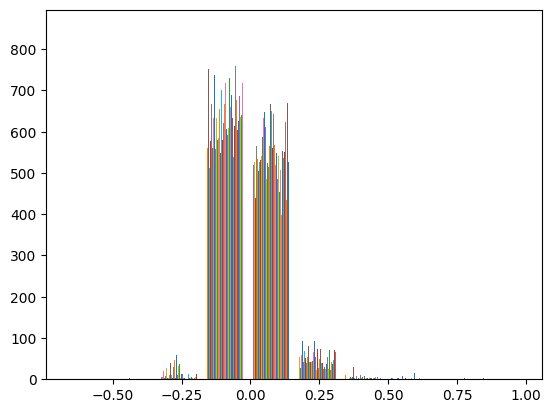

In [126]:
plt.hist(gene_peak_correlations)

### EDA: cosine similarity instead of pearson correlation (for efficient computing)

In [98]:
# computing cosine similarity between RNA and ATAC across metacells (for each gene/peak pair)

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

# extract the log-norm count matrices for RNA and ATAC
rna_matrix = rna_subset.X
atac_matrix = atac_subset.X

# # Normalize the matrices (important for cosine similarity)
# rna_normalized = rna_matrix.multiply(1 / np.sqrt(rna_matrix.power(2).sum(axis=0)))
# atac_normalized = atac_matrix.multiply(1 / np.sqrt(atac_matrix.power(2).sum(axis=0)))

# Compute cosine similarity which is a proxy for Pearson correlation for normalized data
similarity_matrix = cosine_similarity(rna_matrix.T, atac_matrix.T)

# Creating the DataFrame for gene-peak correlations
gene_peak_correlation_df = pd.DataFrame(
    data=similarity_matrix,
    index=rna_subset.var_names,
    columns=atac_subset.var_names
)

(array([[402., 187., 186., ...,   0.,   0.,   0.],
        [287., 170., 153., ..., 121., 263.,   2.],
        [282., 152., 114., ...,  89., 150., 210.],
        ...,
        [454., 200., 181., ...,   0.,   0.,   0.],
        [408., 209., 176., ...,   0.,   0.,   0.],
        [404., 208., 170., ...,   0.,   0.,   0.]]),
 array([0.        , 0.09932981, 0.19865962, 0.29798944, 0.39731925,
        0.49664906, 0.59597887, 0.69530869, 0.7946385 , 0.89396831,
        0.99329812]),
 <a list of 21502 BarContainer objects>)

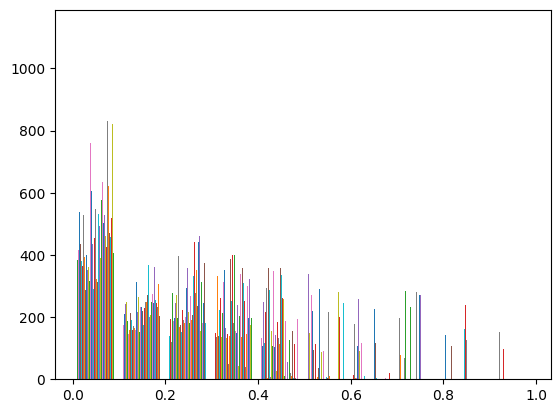

In [99]:
plt.hist(gene_peak_correlation_df)

In [81]:
from scipy import stats
stats.pearsonr(rna_subset.X[:,1], atac_subset.X[:,1])

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [78]:
rna_subset.X[:,1]

<180x1 sparse matrix of type '<class 'numpy.float64'>'
	with 176 stored elements in Compressed Sparse Row format>

In [ ]:
# computing the correlation coefficients between two sparse matrices


In [75]:
rna_subset.X[:,1].T.dot(atac_subset.X[:,1]).todense()

matrix([[2.68021428]])

In [59]:
np.corrcoef(rna_subset.raw.X.T, atac_subset.raw.X.T)

AttributeError: 'float' object has no attribute 'shape'

In [ ]:
chrom = "1"

# subset the adata_rna for one chromosome
rna_subset = rna_meta_ad[:,rna_meta_ad.var["chromosome"]==chrom]

# subset the adata_atac for one chromosome
atac_subset = atac_meta_ad[:,atac_meta_ad.var["chromosome"]==chrom]

    # Compute correlation (example uses Pearson correlation)
    # Adjust the correlation method if needed
    corr_matrix = pd.DataFrame(
        data=np.corrcoef(rna_subset.raw.X.T, atac_subset.T),
        index=adata_rna.var_names[adata_rna.var['chromosome'] == chromosome],
        columns=adata_atac.var_names[adata_atac.var['chromosome'] == chromosome]
    )

# create an empty dataframe for genes-by-peaks
correlation = pd.DataFrame(data=)